# Integration in gene space using transmorph

In this notebook, we use MNNCorrection to integrate datasets in gene space.

## Loading data

In [1]:
from transmorph.datasets import load_chen_10x

# Format: {patient_label -> AnnData}
datasets = load_chen_10x()

databank_api > Loading bank chen_10x.
databank_api > Bank chen_10x successfully loaded.


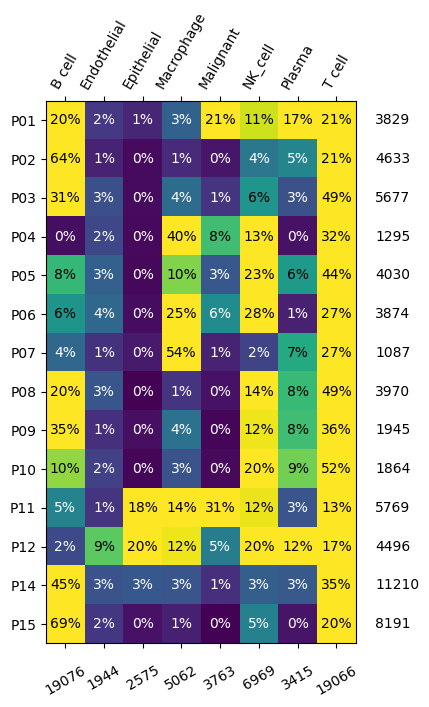

In [6]:
# Displaying cell type distribution across batches
import transmorph.utils.plotting as trplt

trplt.plot_label_distribution_heatmap(datasets, label="class")

In [3]:
trplt.reduce_dimension(datasets, output_obsm='base_umap')

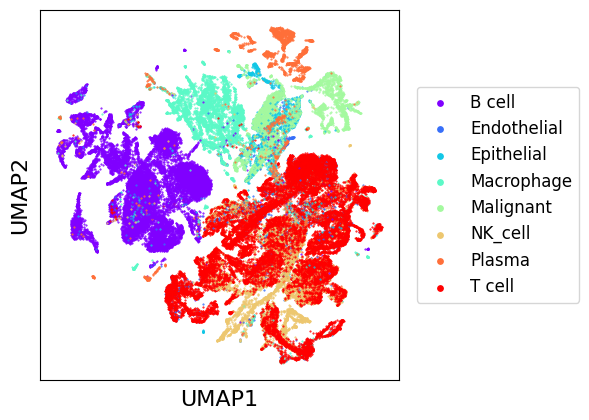

In [4]:
trplt.scatter_plot(datasets, use_rep="base_umap", color_by="class")

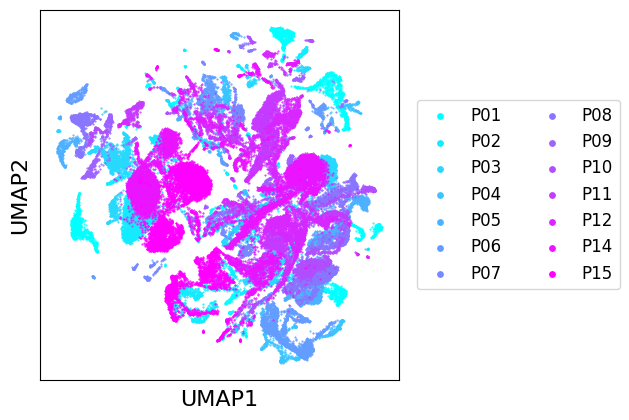

In [5]:
trplt.scatter_plot(datasets, use_rep="base_umap", palette="cool")

## MNNCorrection

In [95]:
from transmorph.models import MNNCorrection

bknn_model = MNNCorrection(matching="bknn")
bknn_model.transform(datasets, reference=datasets["P12"])

MNN_CORRECTION > Transmorph model is initializing.
MNN_CORRECTION > Ready to start the integration of 14 datasets, 61870 total samples.
MNN_CORRECTION > Running layer LAYER_INPUT#0.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#1.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#2.
MNN_CORRECTION > Running layer LAYER_MATCHING#3.
LAYER_MATCHING#3 > Calling matching MATCHING_MNN.
MNN_CORRECTION > Running layer LAYER_MERGING#4.
LAYER_MERGING#4 > Running merging MERGING_LINEAR_CORRECTION...
MNN_CORRECTION > Running layer LAYER_OUTPUT#5.
MNN_CORRECTION > Terminated. Total embedding shape: (61870, 924)
MNN_CORRECTION > Results have been written in AnnData.obsm['X_transmorph'].


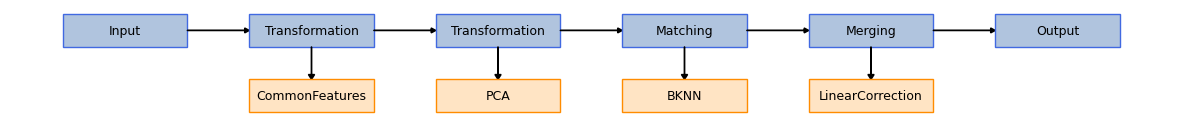

In [6]:
from transmorph.utils.plotting import plot_model

plot_model(bknn_model)

In [9]:
import anndata as ad
import numpy as np

X_tot = np.zeros((0,924))
obs_batch = np.zeros((0,))
obs_class = np.zeros((0,))
obs_names = np.zeros((0,))
for name, adata in datasets.items():
    X_tot = np.concatenate((X_tot, adata.obsm['X_transmorph']))
    obs_batch = np.concatenate((obs_batch, [name]*adata.n_obs))
    obs_class = np.concatenate((obs_class, adata.obs['class']))
    obs_names = np.concatenate((obs_names, adata.obs_names))
    
adata_tot = ad.AnnData(X_tot, dtype=np.float32)
adata_tot.obs_names = obs_names
adata_tot.var_names = bknn_model.embedding_features
adata_tot.obs["class"] = obs_class
adata_tot.obs['batch'] = obs_batch

In [10]:
adata_tot.write_h5ad('data/counts_correction_bknn_v2.h5ad')

## Analysis

In [2]:
import anndata as ad

adata_bknn = ad.read_h5ad('data/counts_correction_bknn_v2.h5ad')

In [ ]:
trplt.reduce_dimension(adata_bknn, output_obsm='bknn_umap')

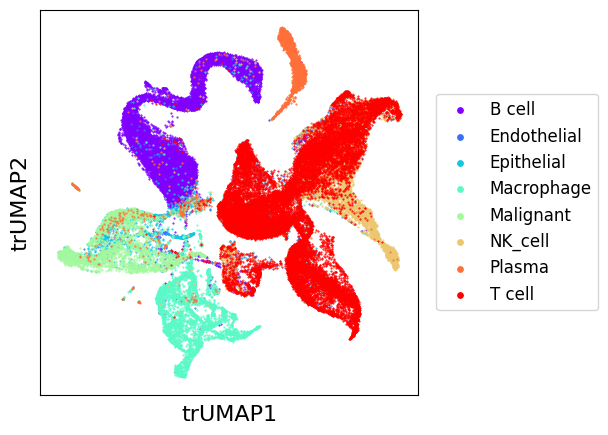

In [9]:
trplt.scatter_plot(adata_bknn, use_rep="bknn_umap", color_by="class", xlabel="trUMAP1", ylabel="trUMAP2")

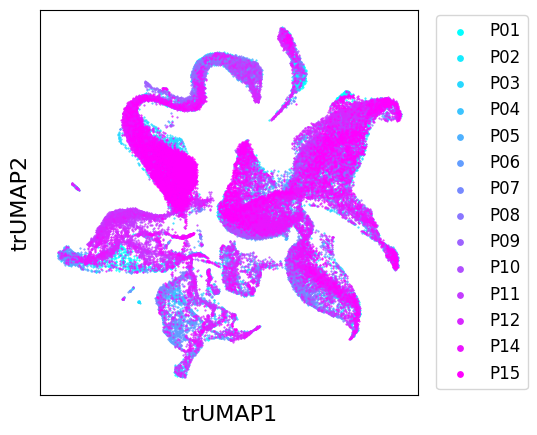

In [10]:
trplt.scatter_plot(adata_bknn, use_rep="bknn_umap", palette="cool", color_by="batch", xlabel="trUMAP1", ylabel="trUMAP2")

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

In [109]:
from transmorph.stats import lisi

lisib = {}
lisib['base'] = lisi(datasets, perplexity=30)
lisib['base'].append(np.concatenate(lisib['base'], axis=0))
lisib['bknn'] = lisi(datasets, obsm="X_transmorph", perplexity=30)
lisib['bknn'].append(np.concatenate(lisib['bknn'], axis=0))

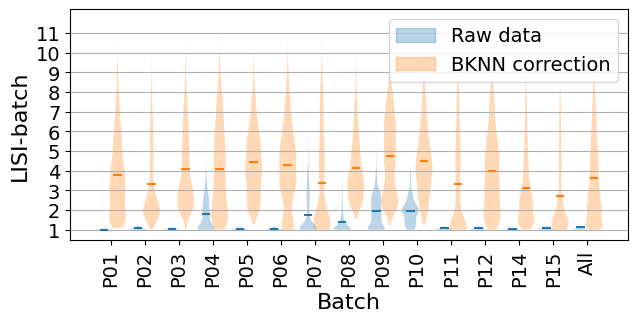

In [110]:
batch_order = np.argsort(list(datasets.keys()))
lisib['base'] = [lisib['base'][i] for i in batch_order] + [lisib['base'][-1]]
lisib['bknn'] = [lisib['bknn'][i] for i in batch_order] + [lisib['bknn'][-1]]

plt.figure(figsize=(8,3))
vp_b_base = plt.violinplot(lisib['base'], positions=np.arange(15)-.2, widths=.5, showmeans=True, showextrema=False)
vp_b_bknn = plt.violinplot(lisib['bknn'], positions=np.arange(15)+.2, widths=.5, showmeans=True, showextrema=False)

labels = []
add_label(vp_b_base, "Raw data")
add_label(vp_b_bknn, "BKNN correction")

plt.xticks(np.arange(15), list(sorted(datasets.keys())) + ['All'], fontsize=14, rotation=90)
plt.yticks(1+np.arange(11), fontsize=14)
plt.ylabel('LISI-batch', fontsize=16)
plt.xlabel('Batch', fontsize=16)

ax = plt.gca()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
plt.legend(
    *zip(*labels), 
    fontsize=14
)

plt.grid(axis="y")
pass

In [114]:
lisic = {}
lisic['base'] = lisi(datasets, obs="class", perplexity=30)
lisic['bknn'] = lisi(datasets, obs="class", obsm="X_transmorph", perplexity=30)

In [115]:
all_classes = set(np.concatenate([adata.obs['class'] for adata in datasets.values()], axis=0))
lisi_c_perclass = {}
for rep in lisic:
    lisi_rep = []
    for ctype in all_classes:
        lisi_ctype = np.zeros((0,))
        for adata, lisi_adata in zip(datasets.values(), lisic[rep]):
            lisi_ctype = np.concatenate((lisi_ctype, lisi_adata[adata.obs['class'] == ctype]))
        lisi_rep.append(lisi_ctype)
    lisi_c_perclass[rep] = lisi_rep

In [116]:
for rep in lisic:
    lisi_c_perclass[rep].append(np.concatenate(lisi_c_perclass[rep], axis=0))

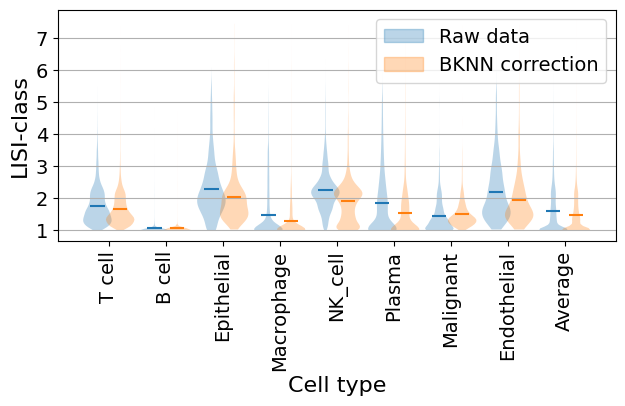

In [122]:
plt.figure(figsize=(8,3))
vp_b_base = plt.violinplot(lisi_c_perclass['base'], positions=np.arange(9)-.2, widths=.5, showmeans=True, showextrema=False)
vp_b_bknn = plt.violinplot(lisi_c_perclass['bknn'], positions=np.arange(9)+.2, widths=.5, showmeans=True, showextrema=False)

labels = []
add_label(vp_b_base, "Raw data")
add_label(vp_b_bknn, "BKNN correction")

plt.xticks(np.arange(9), list(all_classes) + ['Average'], fontsize=14, rotation=90)
plt.yticks(1+np.arange(7), fontsize=14)
plt.ylabel('LISI-class', fontsize=16)
plt.xlabel('Cell type', fontsize=16)

ax = plt.gca()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
plt.legend(
    *zip(*labels), 
    fontsize=14
)
plt.grid(axis='y')
pass

## ICA

In [32]:
import sica
import numpy as np
import matplotlib.pyplot as plt

from numpy import corrcoef
from mpl_toolkits.axes_grid1 import make_axes_locatable


N_ICS = 30
cell_type_ica = 'T cell'

def get_ic_batch_signal(ic_coefs, batches):
    coefs = []
    for batch in set(batches):
        y_batch = batches.to_numpy() == batch
        coefs.append(corrcoef(ic_coefs, y_batch)[1, 0])
    return coefs

In [19]:
X_tot = np.zeros((0, len(bknn_model.embedding_features)))
cell_selector = np.zeros((0,), dtype=int)
for adata in datasets.values():
    cell_selector_k = adata.obs['class'] == cell_type_ica
    X_tot = np.concatenate((X_tot, adata[cell_selector_k, bknn_model.embedding_features].X), axis=0)
    cell_selector = np.concatenate((cell_selector, cell_selector_k), axis=0)

ica_model_raw = sica.base.StabilizedICA(n_components=N_ICS, max_iter=2000, n_runs=20)
ica_model_raw.fit(X_tot)

StabilizedICA(n_components=30, n_runs=20)

In [20]:
raw_ica_genevsic = ica_model_raw.S_.T.copy() 
raw_ica_icvscell = (X_tot @ np.linalg.pinv(ica_model_raw.S_)).T

In [21]:
coeficbatch = np.zeros((len(set(adata_bknn.obs['batch'])), N_ICS))
for ic in range(N_ICS):
    coeficbatch[:, ic] = get_ic_batch_signal(raw_ica_icvscell.T[:, ic], adata_bknn.obs['batch'][cell_selector.astype(bool)])

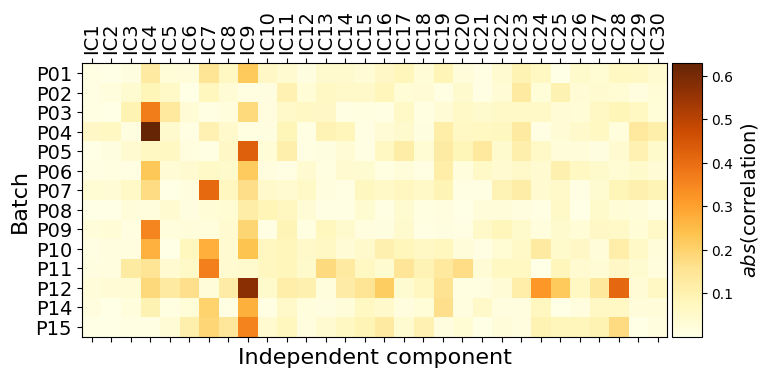

In [24]:
plt.figure(figsize=(8,5))
ax = plt.gca()
im = ax.matshow(np.abs(coeficbatch), cmap='YlOrBr')
plt.xticks(np.arange(30), [f'IC{i+1}' for i in range(30)], rotation=90, fontsize=14)
plt.yticks(np.arange(14), list(datasets.keys()), fontsize=14)
plt.xlabel('Independent component', fontsize=16)
plt.ylabel('Batch', fontsize=16)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)   
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_ylabel('$abs$(correlation)', fontsize=14)
pass

In [25]:
cell_selector = adata_bknn.obs['class'] == cell_type_ica
X_tot = adata_bknn.X[cell_selector]

ica_model_bknn = sica.base.StabilizedICA(n_components=N_ICS, max_iter=2000, n_runs=20)
ica_model_bknn.fit(X_tot)

StabilizedICA(n_components=30, n_runs=20)

In [26]:
bknn_ica_genevsic = ica_model_bknn.S_.T.copy() 
bknn_ica_icvscell = (X_tot @ np.linalg.pinv(ica_model_bknn.S_)).T

In [27]:
coeficbatch2 = np.zeros((len(set(adata_bknn.obs['batch'])), N_ICS))
for ic in range(N_ICS):
    coeficbatch2[:, ic] = get_ic_batch_signal(bknn_ica_icvscell.T[:, ic], adata_bknn.obs['batch'][cell_selector])

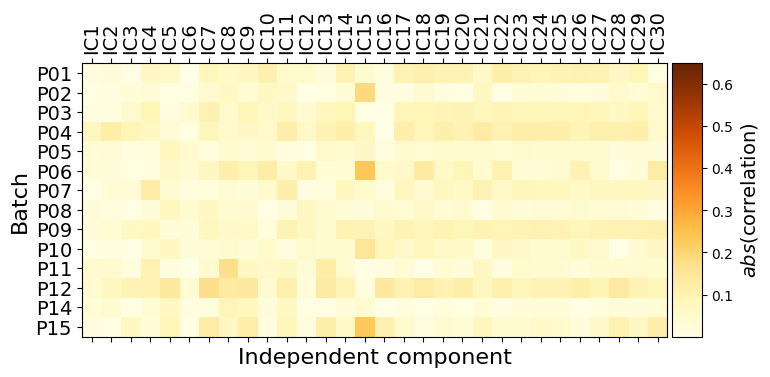

In [28]:
plt.figure(figsize=(8,5))
ax = plt.gca()
im = ax.matshow(np.abs(coeficbatch2), cmap='YlOrBr', vmax=0.65)
plt.xticks(np.arange(30), [f'IC{i+1}' for i in range(30)], rotation=90, fontsize=14)
plt.yticks(np.arange(14), list(datasets.keys()), fontsize=14)
plt.xlabel('Independent component', fontsize=16)
plt.ylabel('Batch', fontsize=16)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)   
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_ylabel('$abs$(correlation)', fontsize=14)
pass

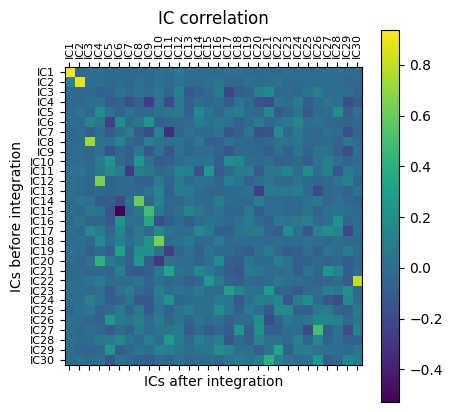

In [29]:
corricic = np.corrcoef(raw_ica_genevsic.T, bknn_ica_genevsic.T)

plt.matshow(corricic[:N_ICS, N_ICS:])
plt.xlabel("ICs after integration")
plt.ylabel("ICs before integration")
plt.title("IC correlation")
plt.xticks(np.arange(N_ICS), [f'IC{i}' for i in range(1, N_ICS+1)], rotation=90, fontsize=8)
plt.yticks(np.arange(N_ICS), [f'IC{i}' for i in range(1, N_ICS+1)], fontsize=8)
plt.colorbar()

## Annotation

In [2]:
import scanpy as sc

adata_bknn = sc.read_h5ad('data/counts_correction_bknn_annotated.h5ad')

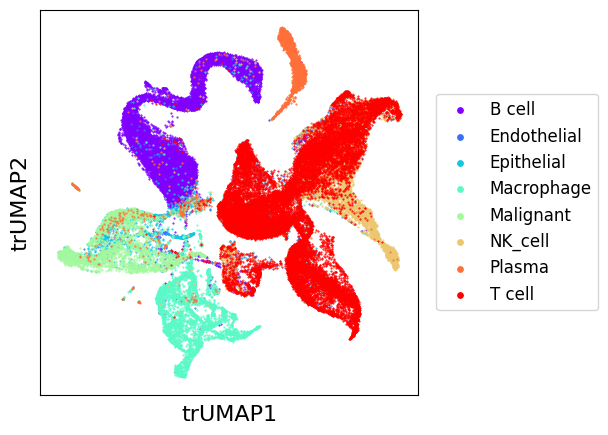

In [4]:
import transmorph.utils.plotting as trplt

trplt.scatter_plot(adata_bknn, use_rep="bknn_umap", color_by="class", xlabel="trUMAP1", ylabel="trUMAP2")

In [31]:
# import scanpy as sc

# sc.pp.pca(adata_bknn)
# sc.pp.neighbors(adata_bknn)
# sc.tl.leiden(adata_bknn, resolution=0.3)

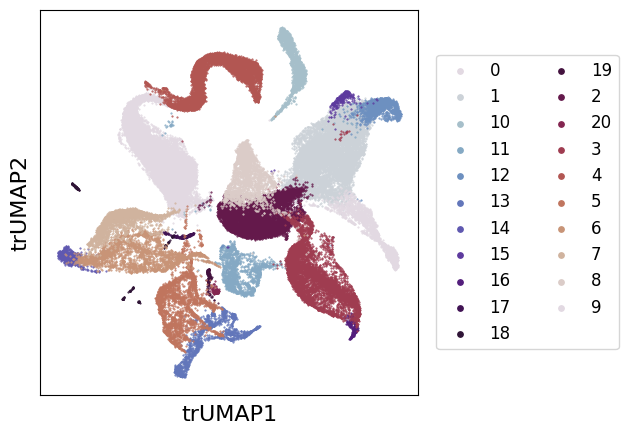

In [7]:
trplt.scatter_plot(adata_bknn, use_rep="bknn_umap", color_by="leiden", palette='twilight', 
                   xlabel="trUMAP1", ylabel="trUMAP2")

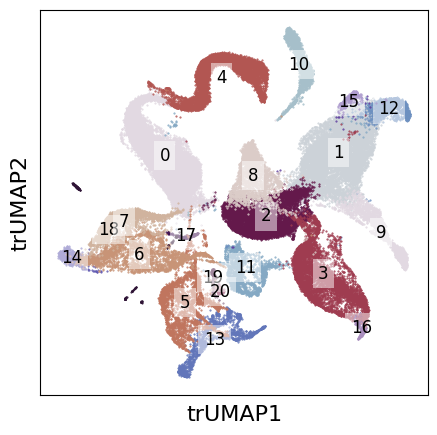

In [8]:
trplt.scatter_plot(adata_bknn, use_rep="bknn_umap", color_by="leiden", palette='twilight', 
                   labels_on_plot=True, xlabel="trUMAP1", ylabel="trUMAP2")

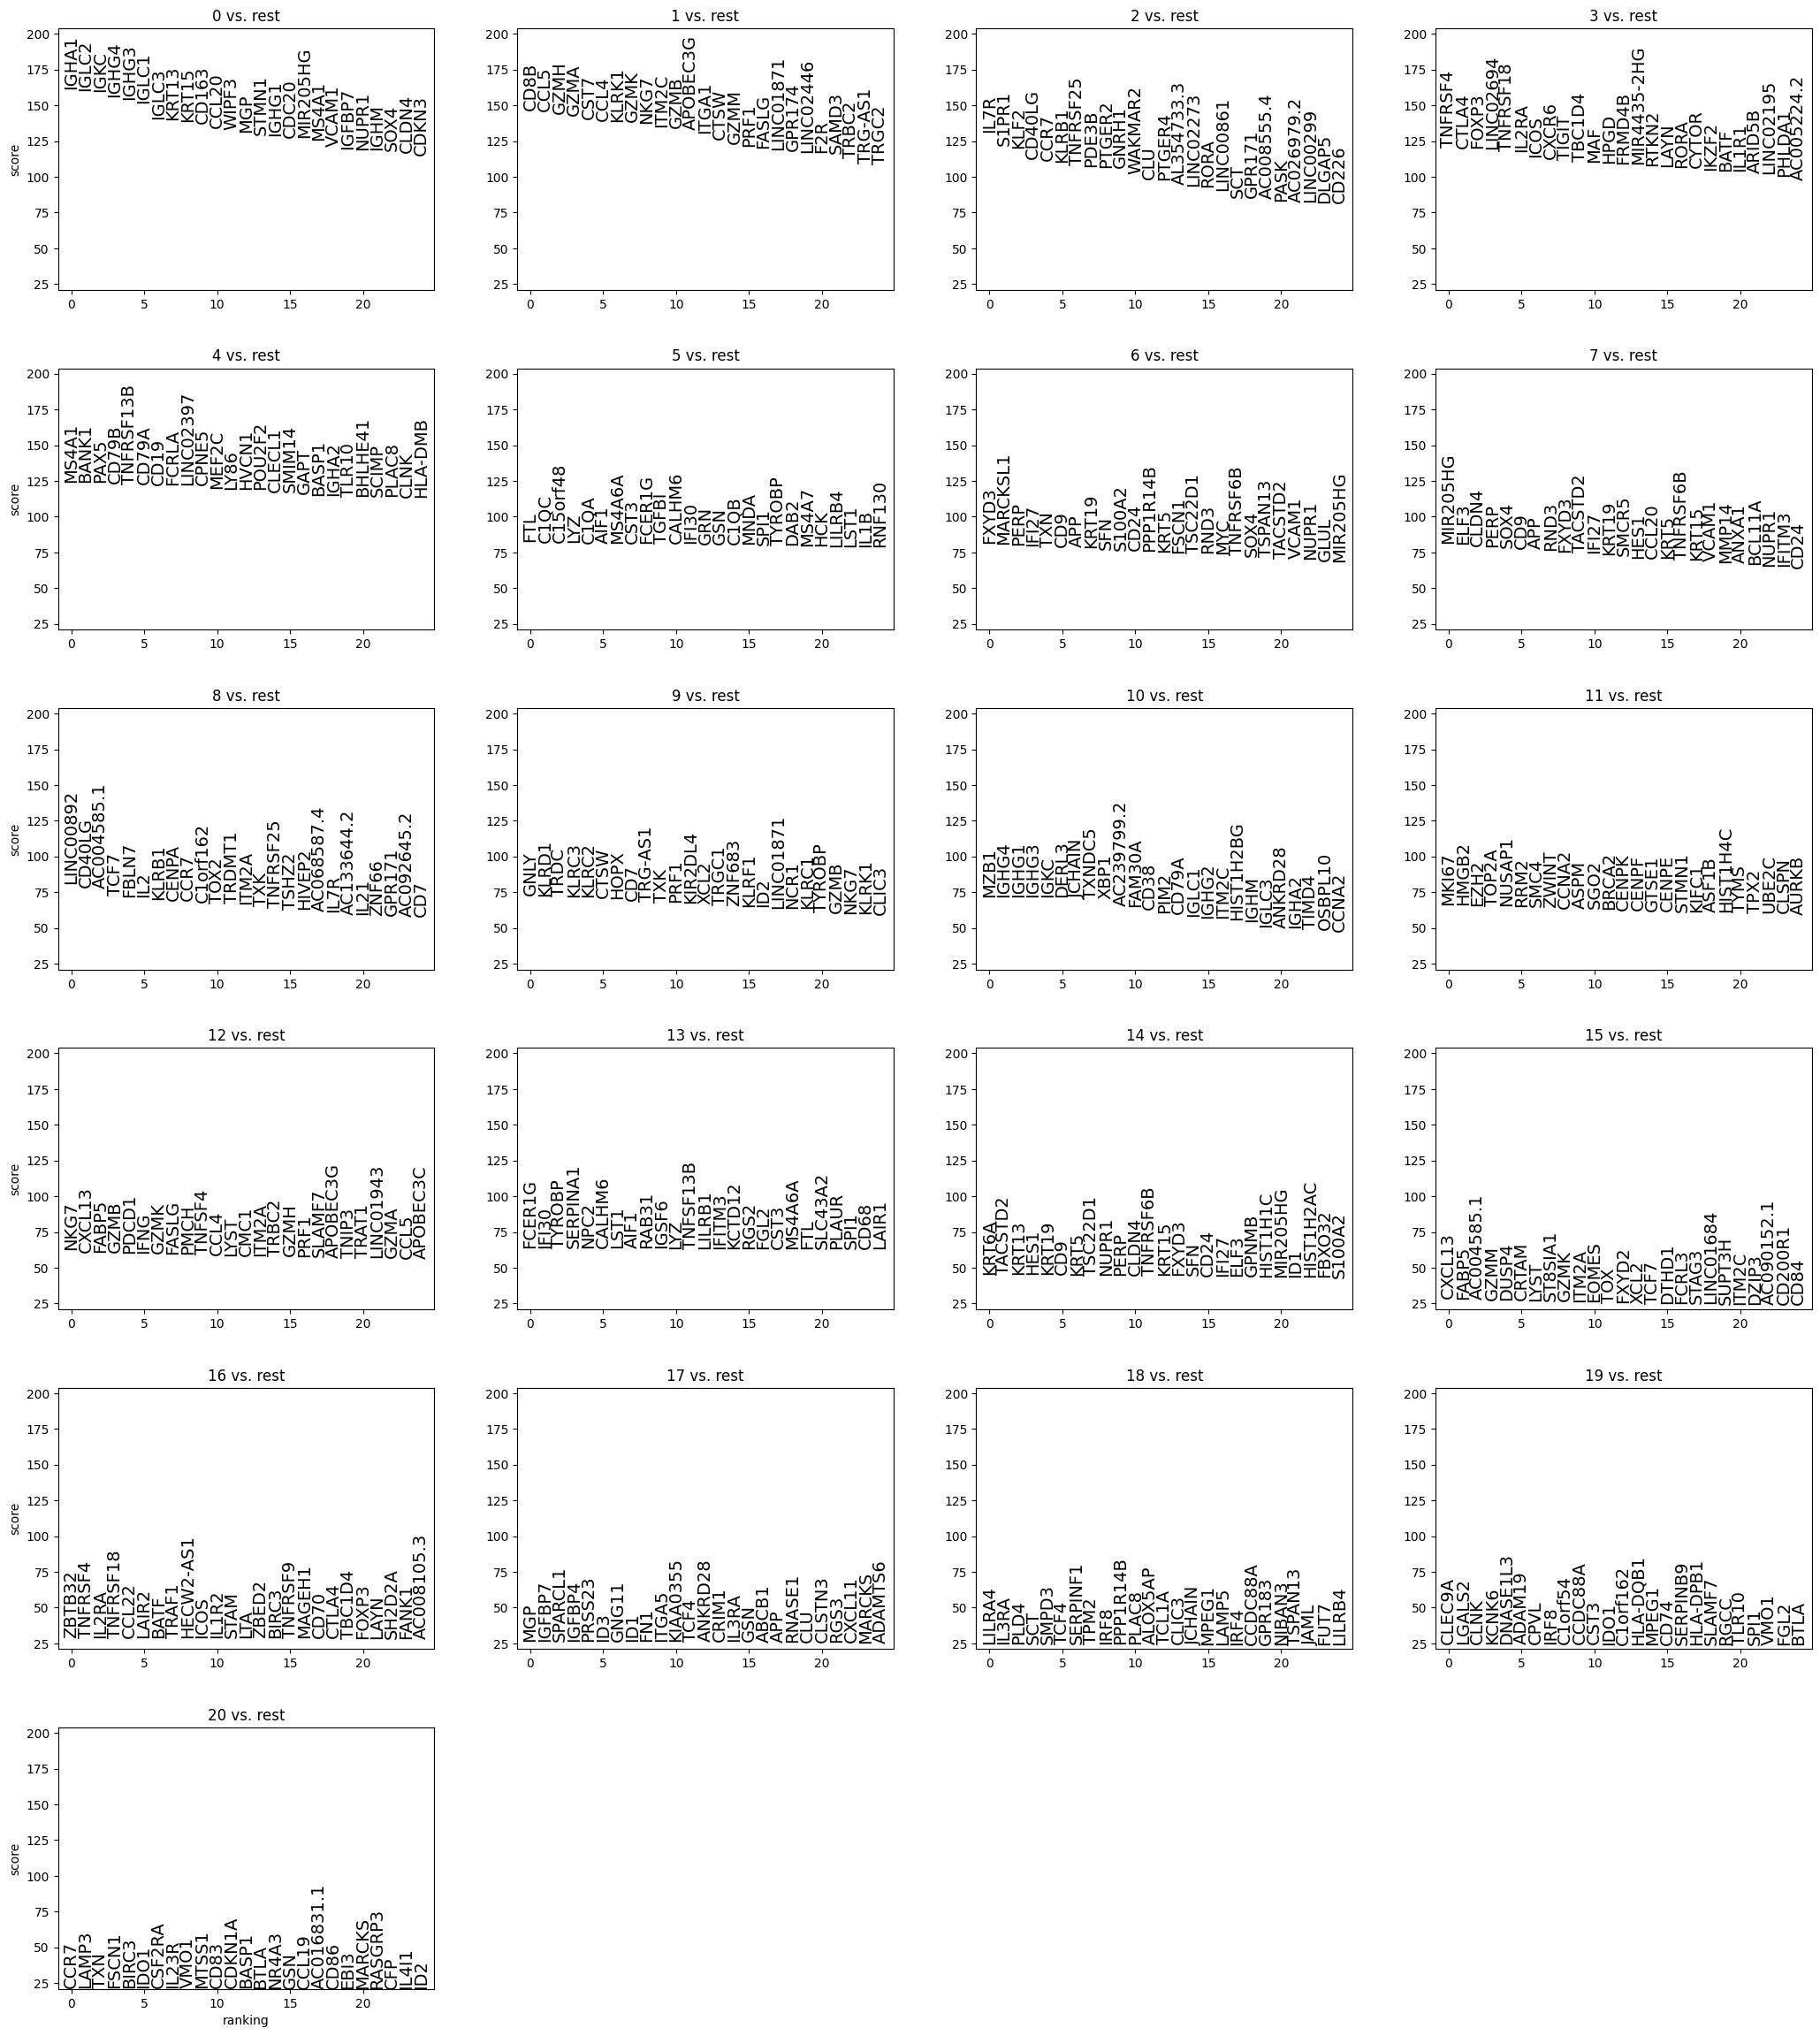

In [121]:
import math

adata_bknn.uns['log1p']['base'] = math.e
sc.tl.rank_genes_groups(adata_bknn, 'leiden', method='wilcoxon', key_added="wilcoxon")
sc.pl.rank_genes_groups(adata_bknn, n_genes=25, key='wilcoxon', fontsize=14)

In [3]:
leiden_to_type = [
    'B-cells',
    'T-CD8+',
    'T-naive',
    'T-CD4+',
    'B-cells',
    'Macrophages',
    'Malignant',
    'Malignant',
    'T-memory',
    'NK-cells',
    'Plasma cells',
    'T-proliferating',
    'NK-cells',
    'Macrophages',
    'Epithelial',
    'T-CD8+',
    'T-CD4+',
    'Endothelial',
    'Macrophages',
    'Dendritic cells',
    'Dendritic cells'
]

inferred_ctypes = [
    leiden_to_type[int(i)] for i in adata_bknn.obs['leiden']
]

In [4]:
# Updating all anndata
adata_bknn.obs['inferred_class'] = inferred_ctypes
offset = 0
for adata in datasets.values():
    adata.obs['inferred_class'] = inferred_ctypes[offset:offset+adata.n_obs].copy()
    offset += adata.n_obs

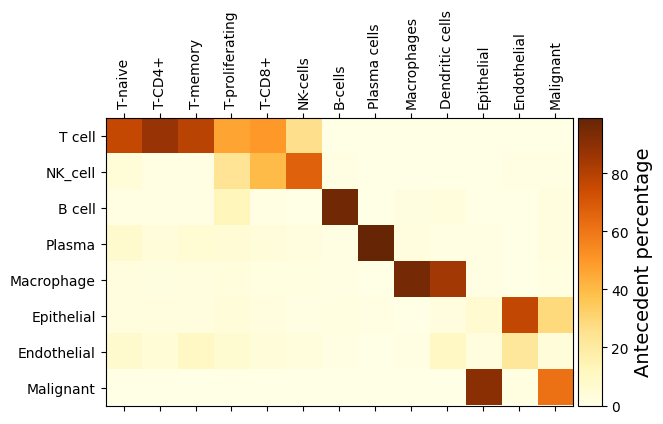

In [89]:
import numpy as np
import matplotlib.pyplot as plt

y_old, y_new = adata_bknn.obs['class'], adata_bknn.obs['inferred_class']

old_labels = ['T cell', 'NK_cell', 'B cell', 'Plasma', 'Macrophage', 
              'Epithelial', 'Endothelial', 'Malignant']
new_labels = ['T-naive', 'T-CD4+','T-memory', 'T-proliferating',  'T-CD8+', 
              'NK-cells', 'B-cells', 'Plasma cells', 'Macrophages', 'Dendritic cells',
              'Epithelial', 'Endothelial', 'Malignant']

intersect = np.zeros((len(set(y_old)), len(set(y_new))))
for i, yi_old in enumerate(old_labels):
    for j, yj_new in enumerate(new_labels):
        intersect[i, j] = np.sum((y_old == yi_old) * (y_new == yj_new))/np.sum((y_new == yj_new))*100

ax = plt.gca()
im = ax.matshow(intersect, cmap='YlOrBr')
plt.xticks(np.arange(len(new_labels)), new_labels, rotation=90)
plt.yticks(np.arange(len(old_labels)), old_labels)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)   
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Antecedent percentage', fontsize=14)
pass

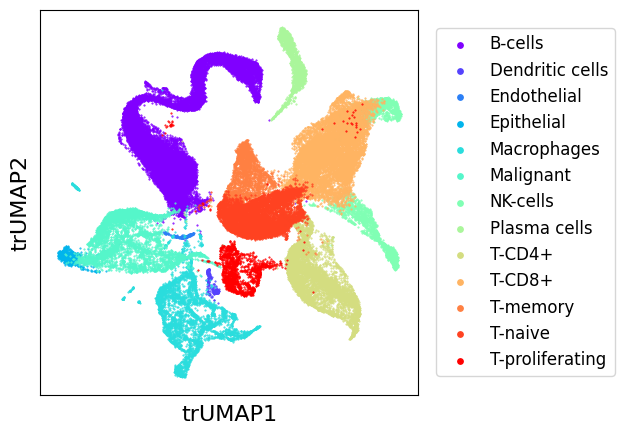

In [7]:
trplt.scatter_plot(adata_bknn, use_rep="bknn_umap", color_by="inferred_class", xlabel="trUMAP1", ylabel="trUMAP2")

In [79]:
# T-proliferating: MKI67, TOP2A, CCNA2
# NK-cells-1: GNLY, KLRC genes
# NK-cells-2: NKG7, interferon gamma
# T-CD4+: CD4 in datasets which express this gene
# T-CD8+: CD8
# Dendritic: CLEC9A, CCR7, LAMP3

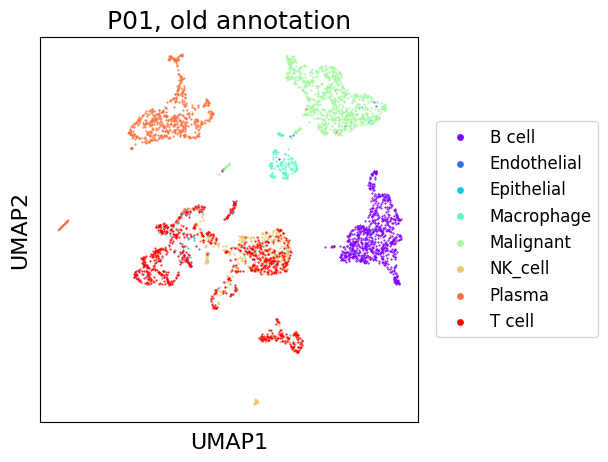

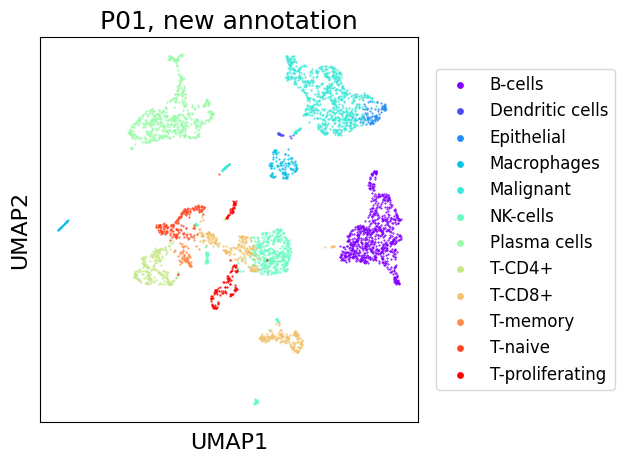

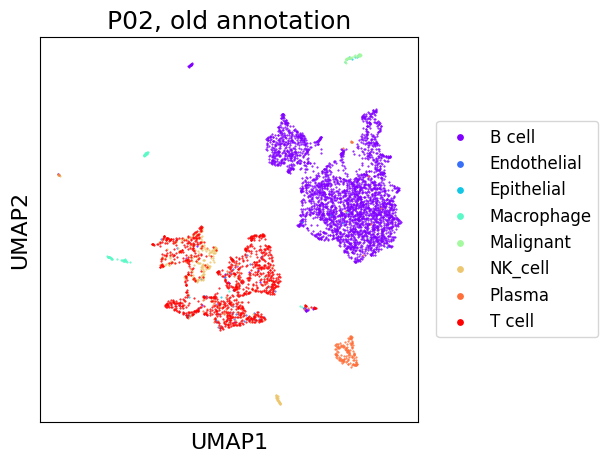

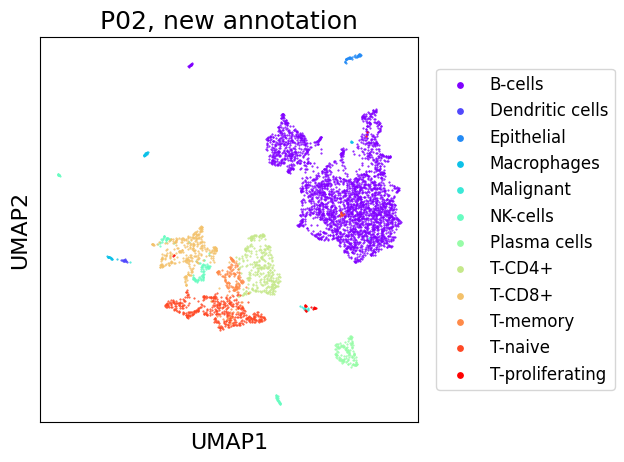

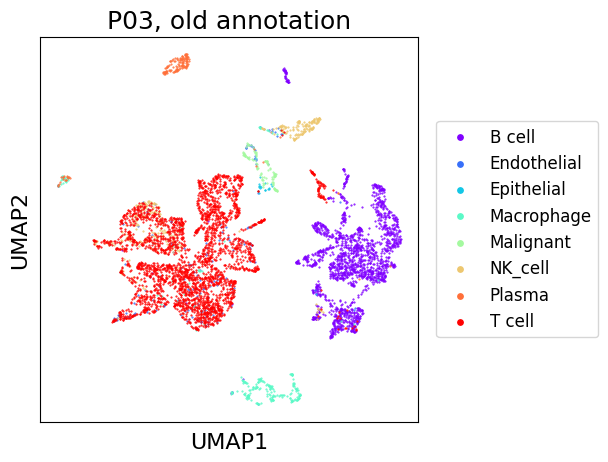

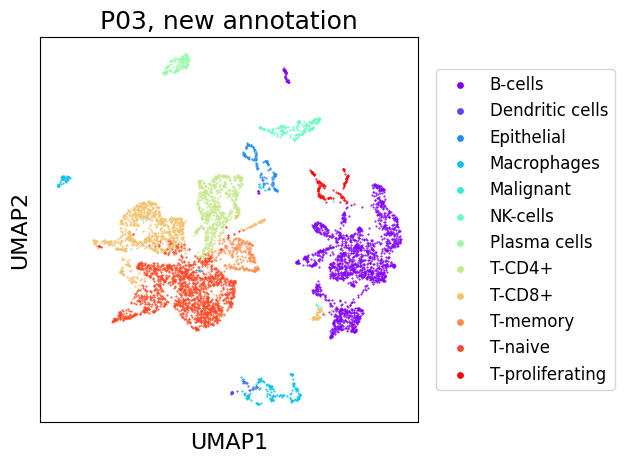

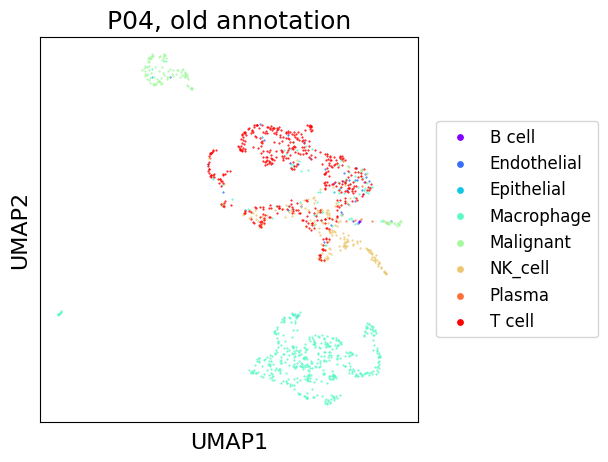

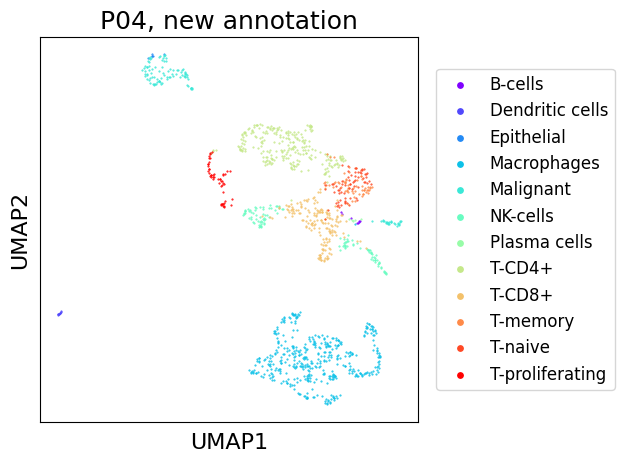

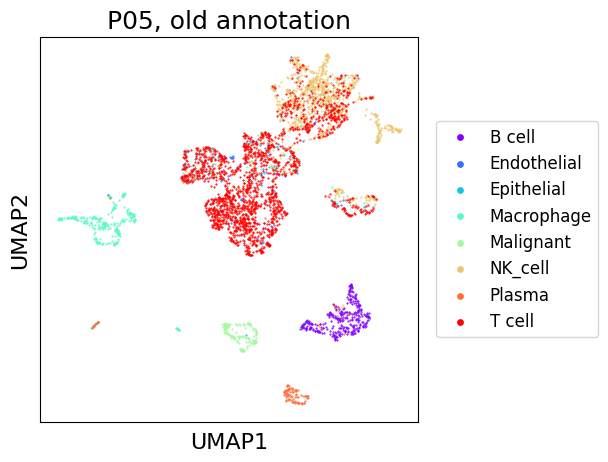

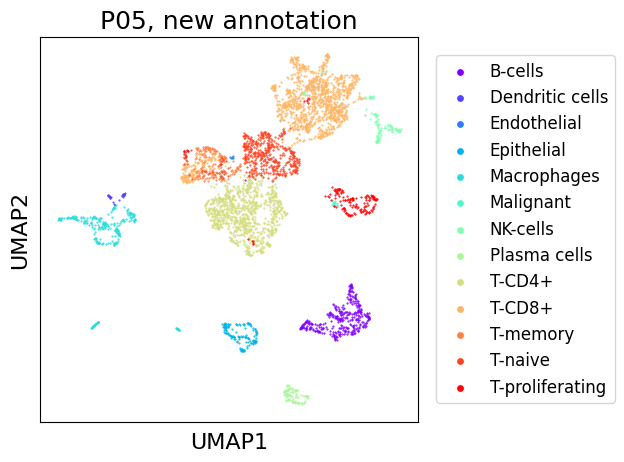

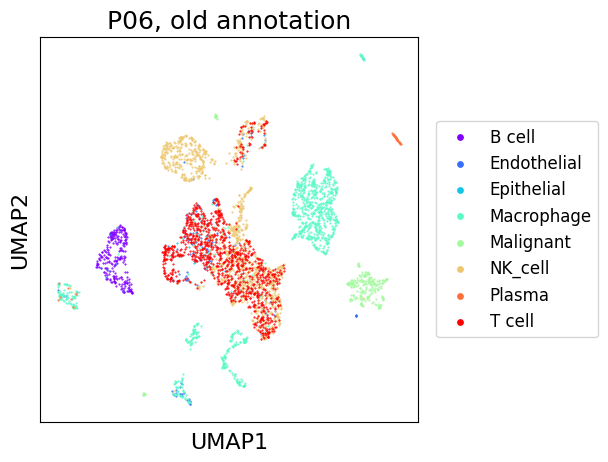

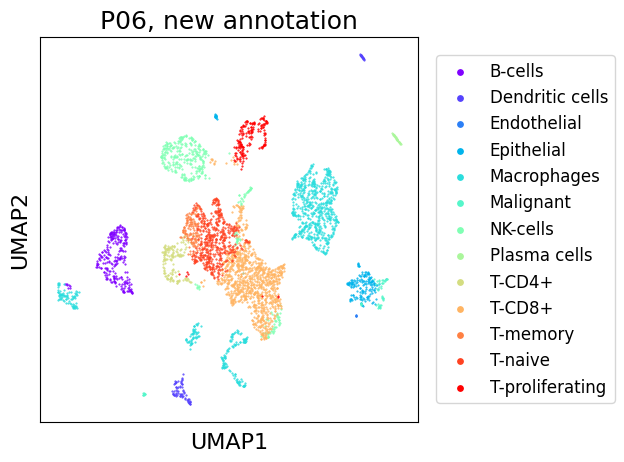

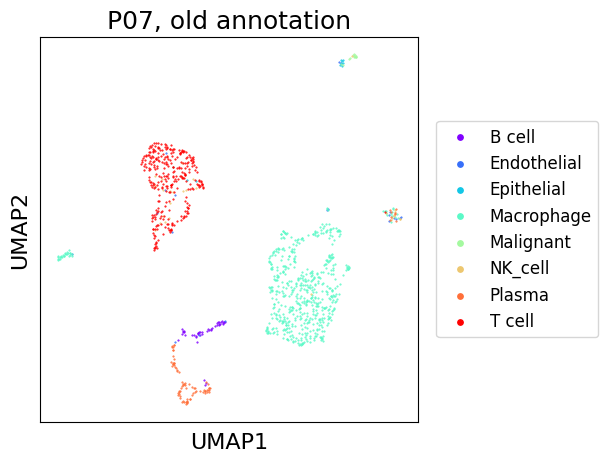

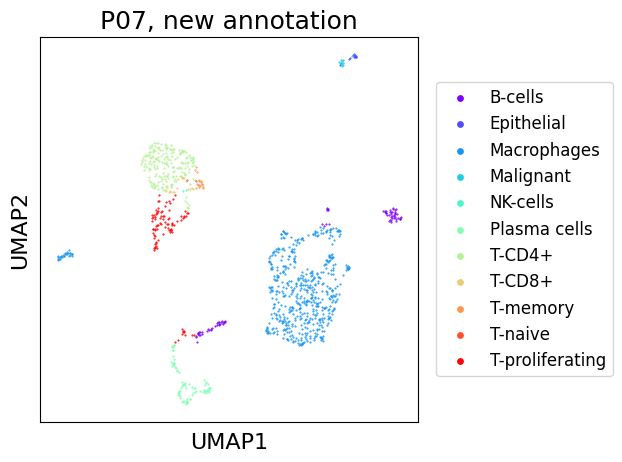

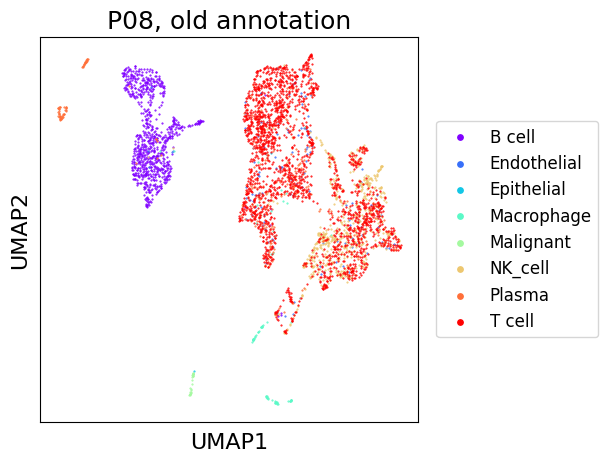

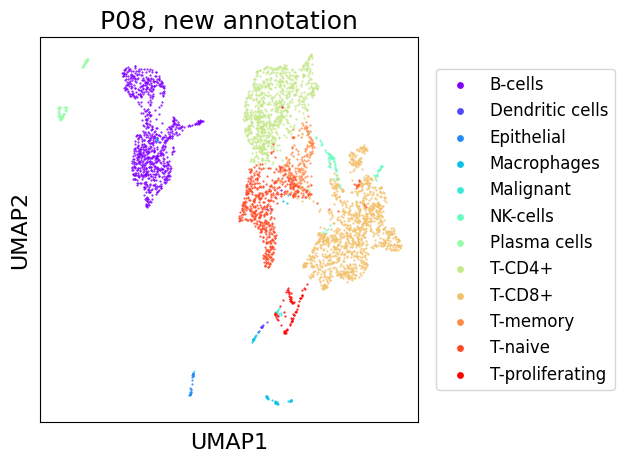

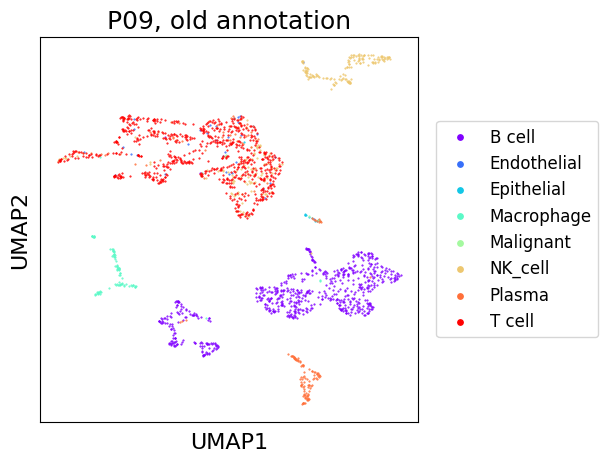

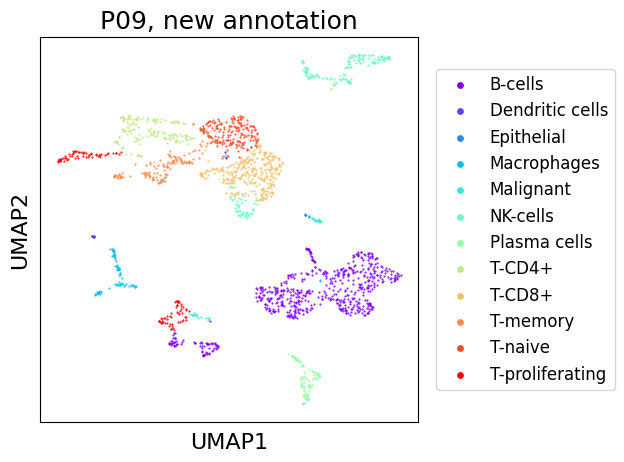

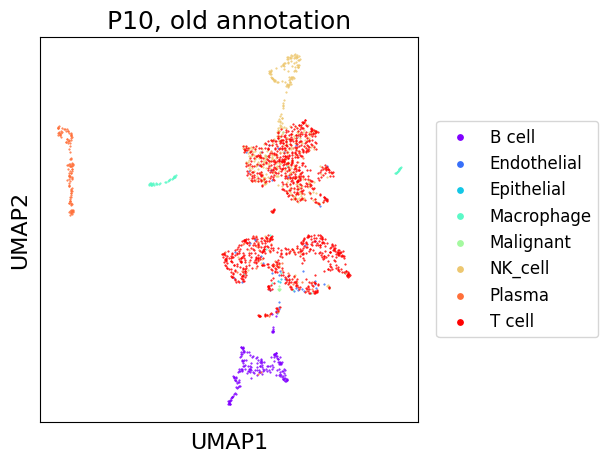

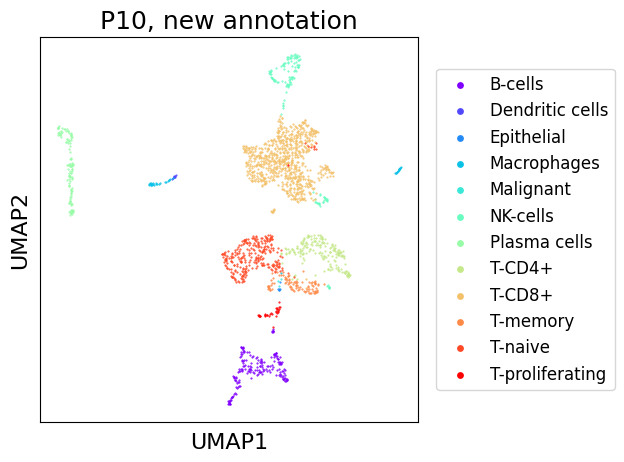

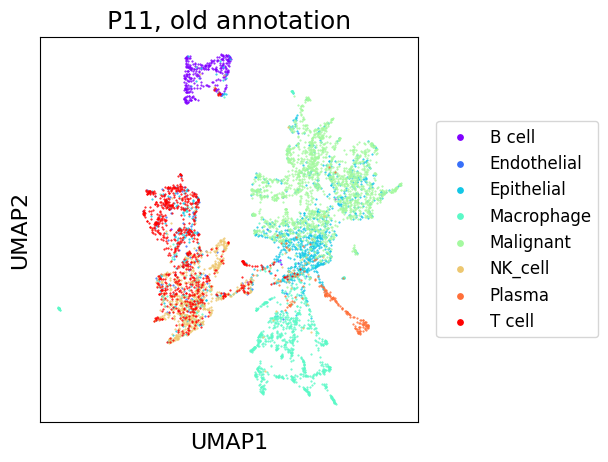

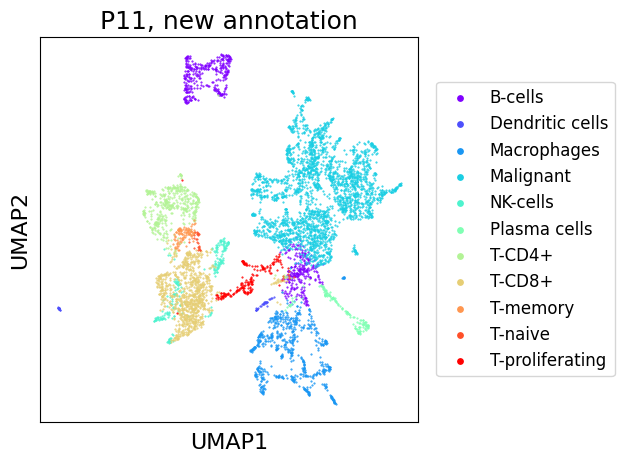

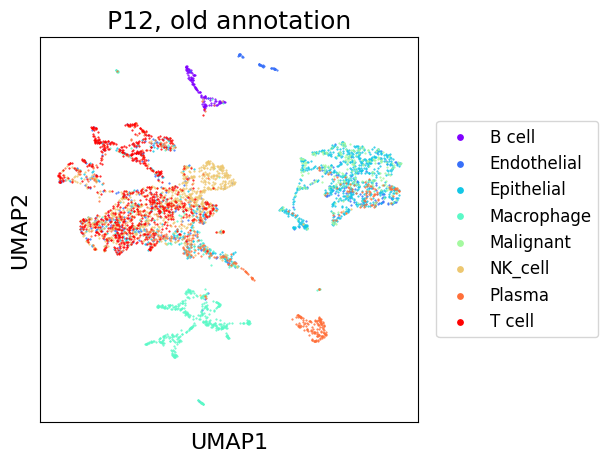

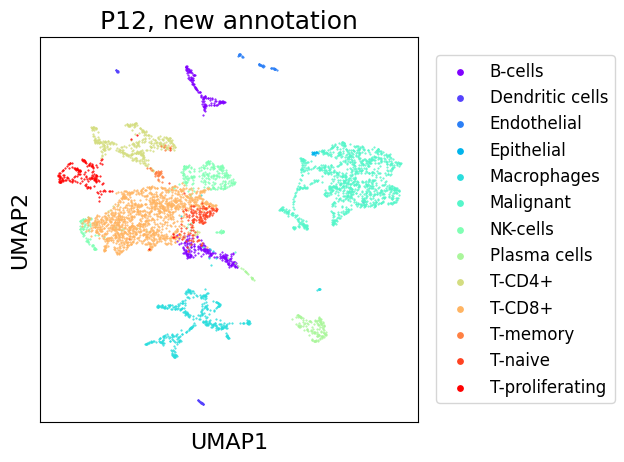

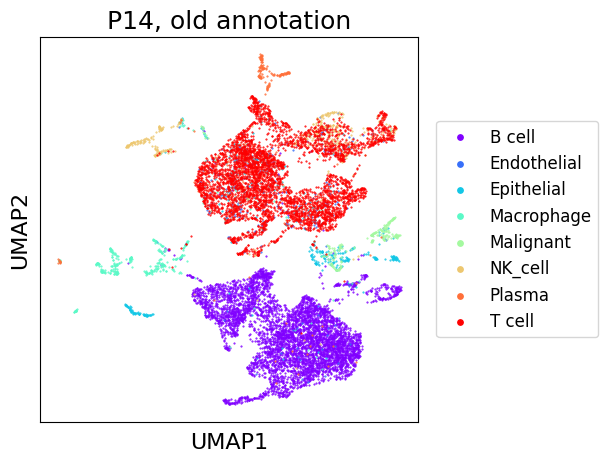

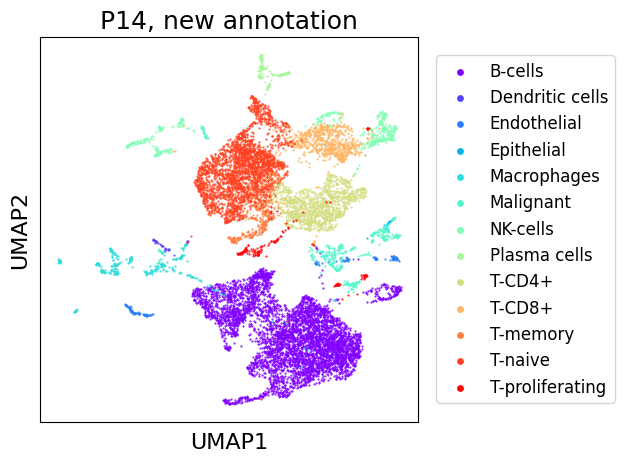

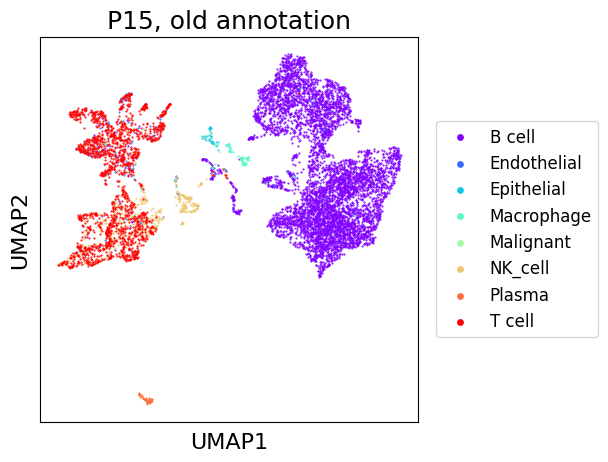

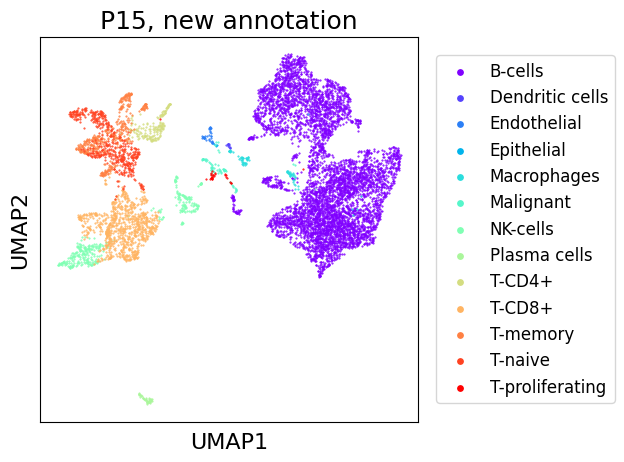

In [12]:
for name, adata in datasets.items():
    if 'X_umap' not in adata.obsm:
        sc.pp.pca(adata)
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)
    trplt.scatter_plot(adata, use_rep="X_umap", color_by="class", title=f"{name}, old annotation", xlabel="UMAP1", ylabel="UMAP2")
    trplt.scatter_plot(adata, use_rep="X_umap", color_by="inferred_class", title=f"{name}, new annotation", xlabel="UMAP1", ylabel="UMAP2")

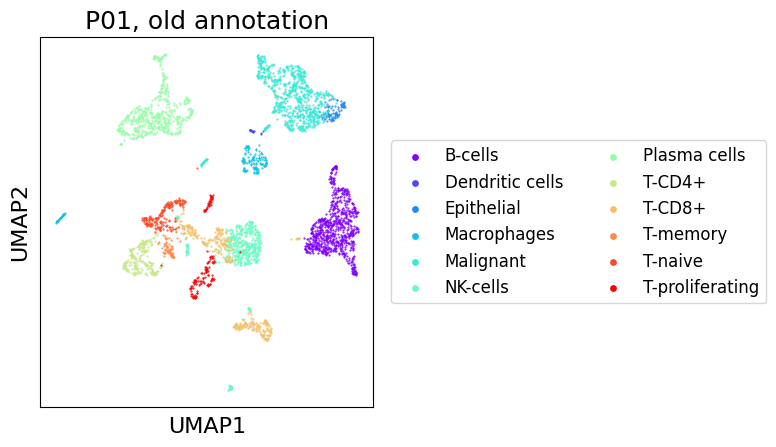

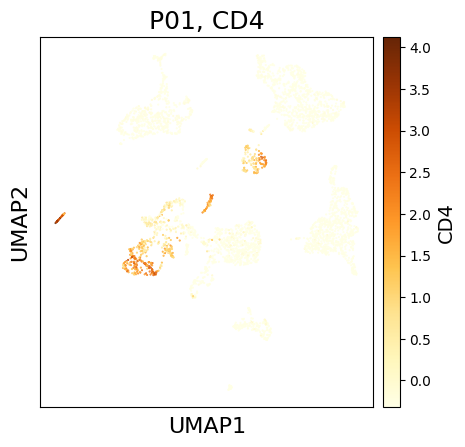

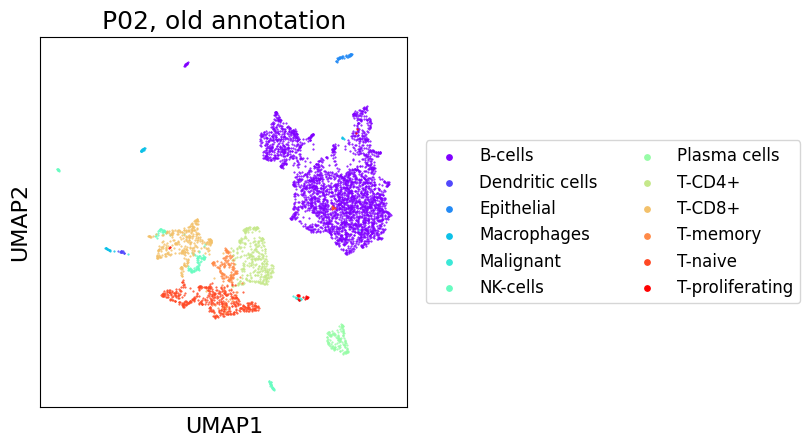

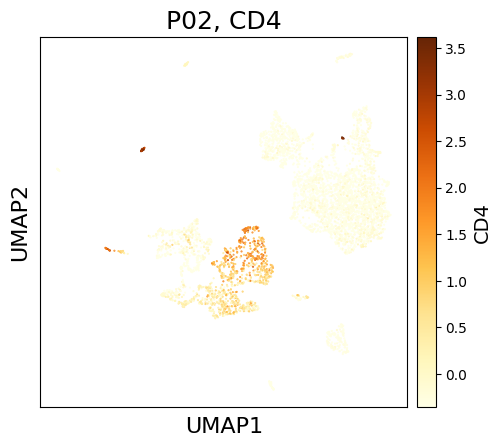

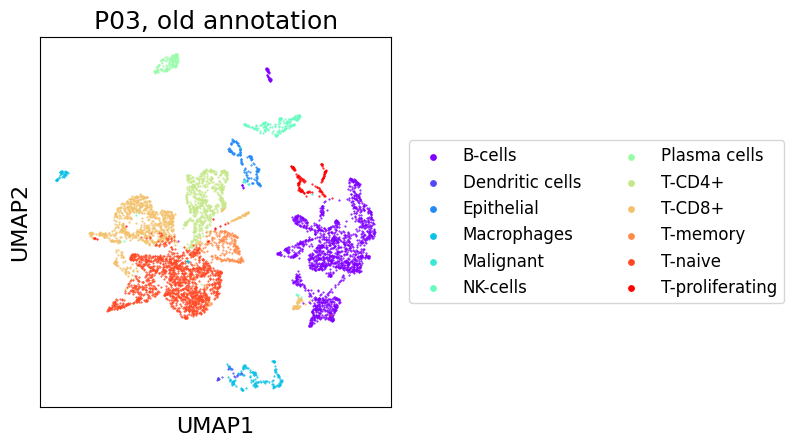

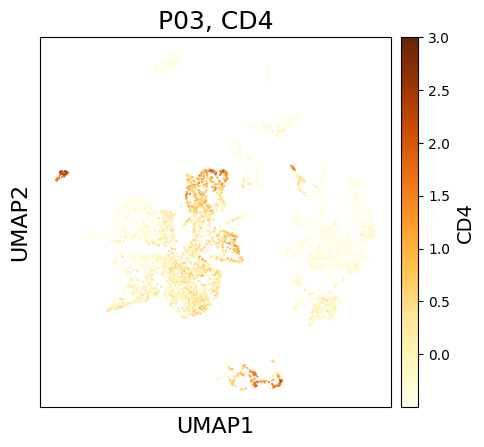

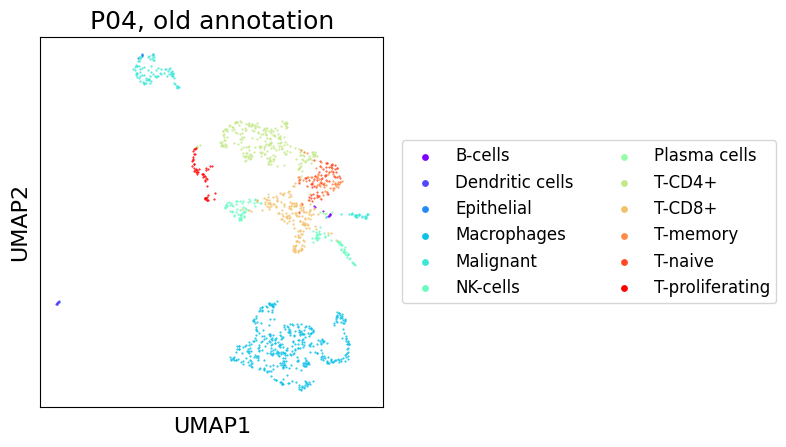

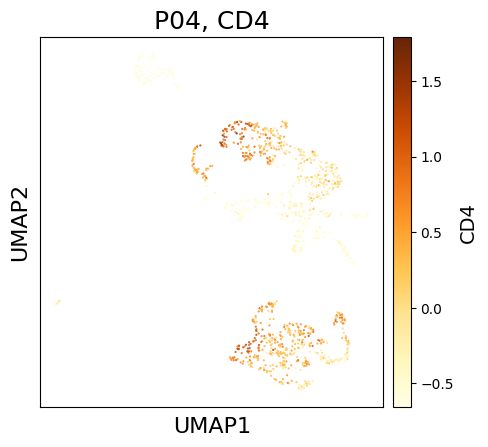

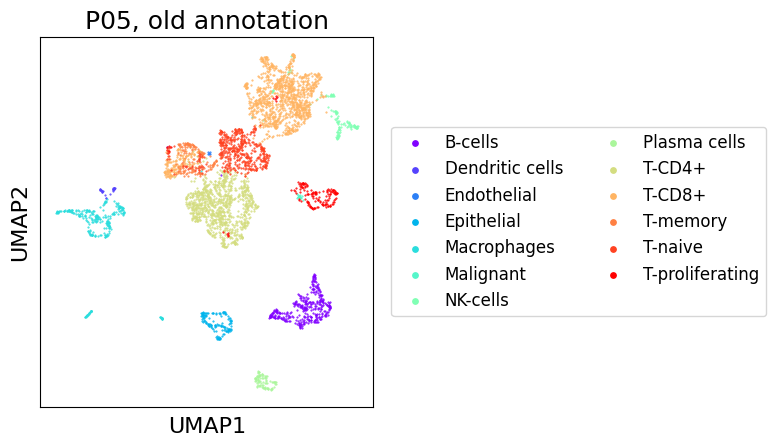

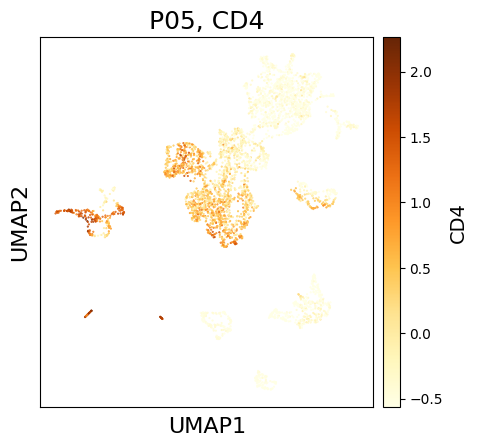

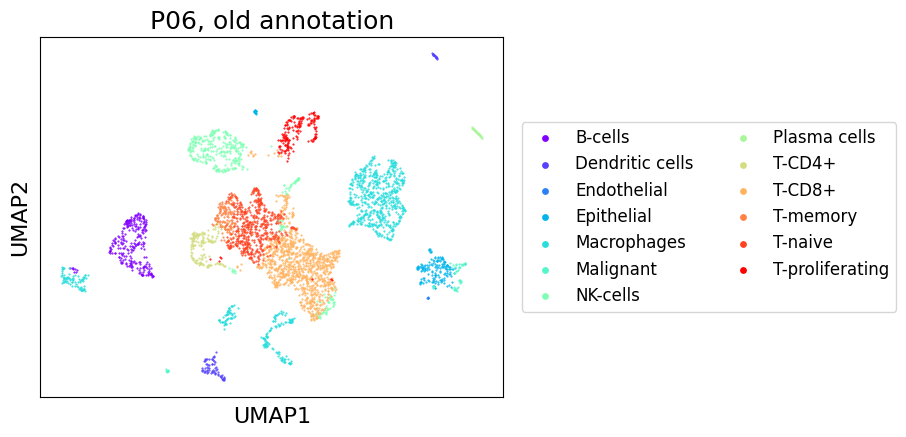

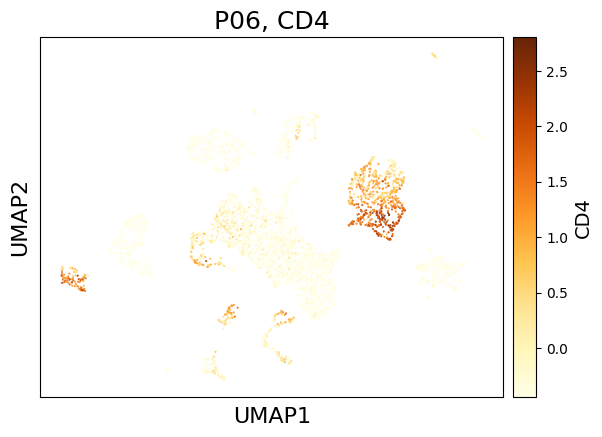

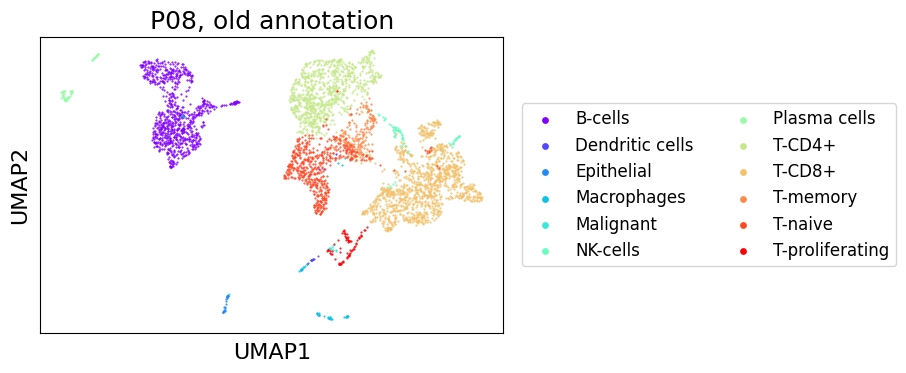

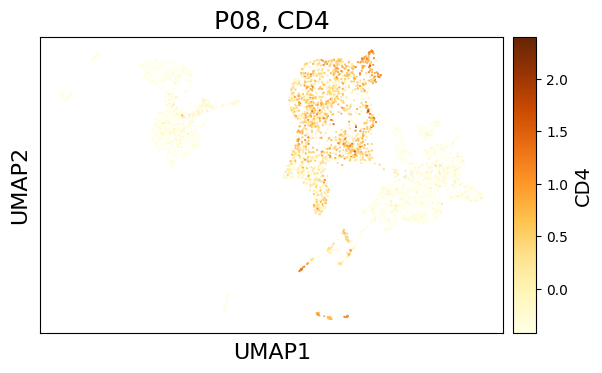

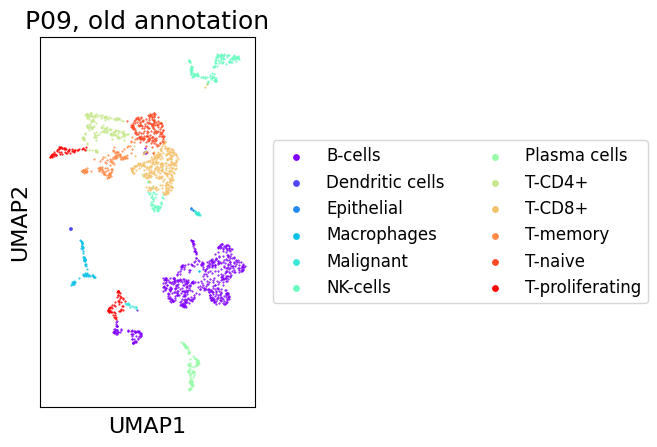

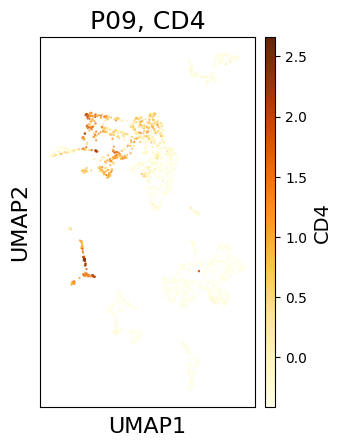

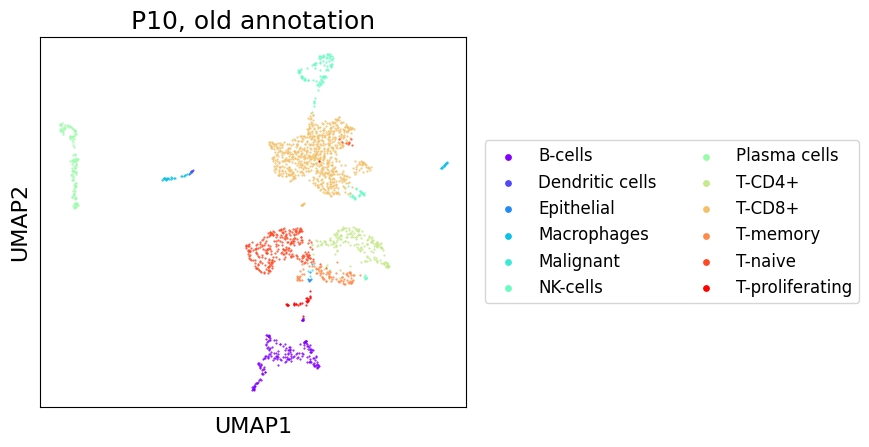

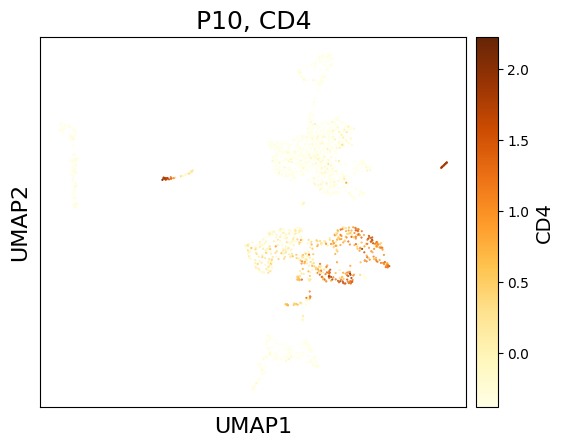

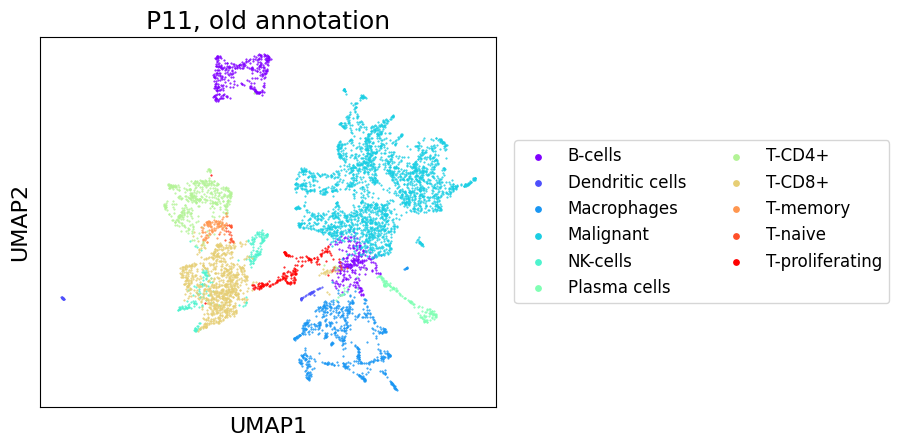

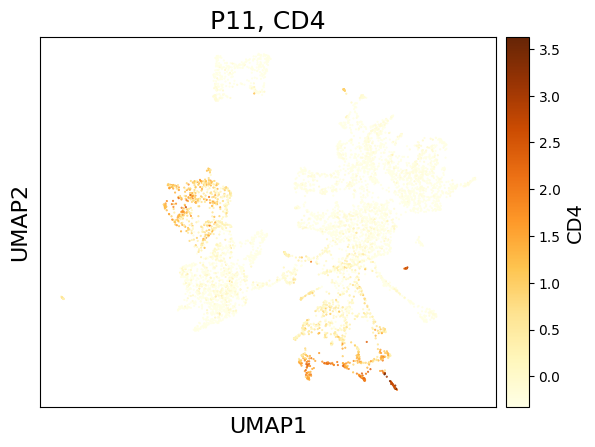

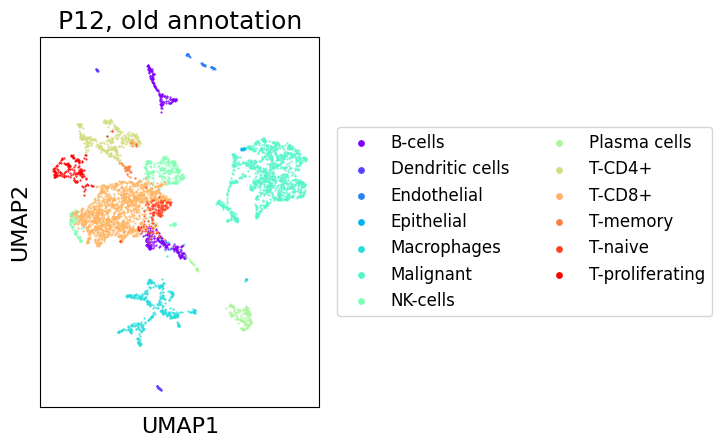

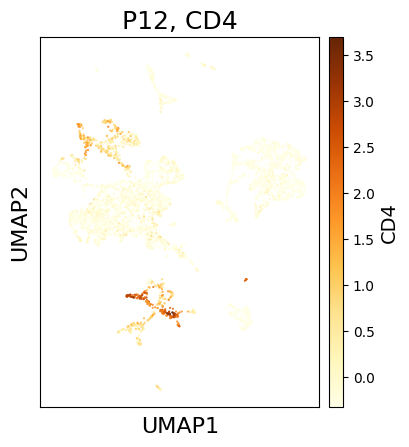

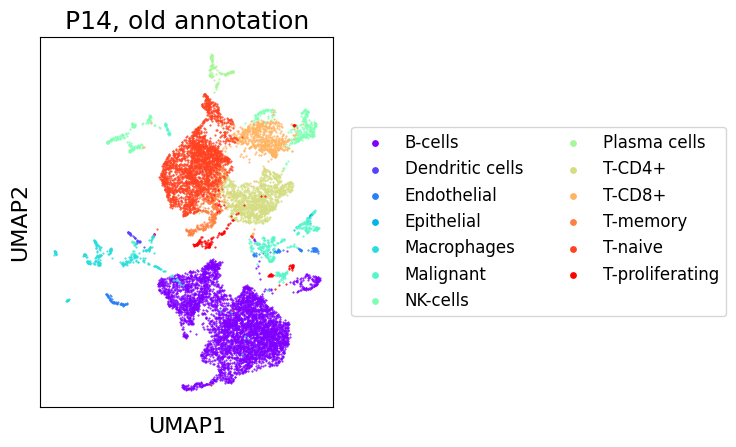

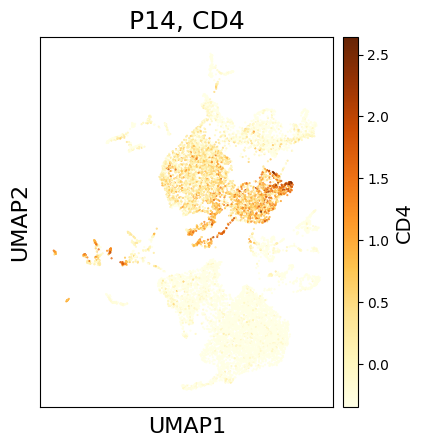

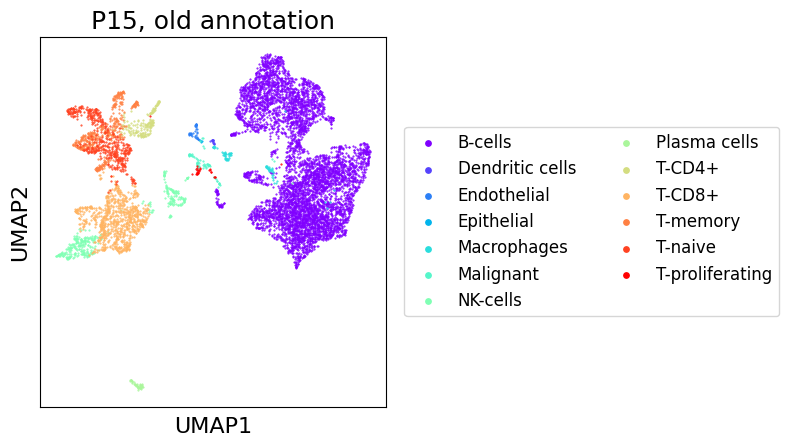

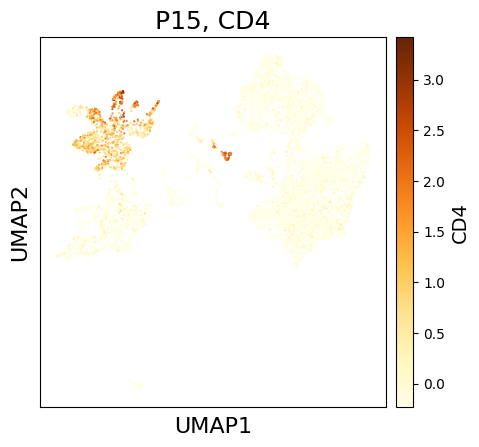

In [92]:
for name, adata in datasets.items():
    if 'CD4' not in adata.var_names:
        continue
    if 'X_umap' not in adata.obsm:
        sc.pp.pca(adata)
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)
    adata.obs['CD4'] = adata[:, 'CD4'].X.copy()
    trplt.scatter_plot(adata, use_rep="X_umap", color_by="inferred_class", title=f"{name}, old annotation", xlabel="UMAP1", ylabel="UMAP2")
    trplt.scatter_plot(adata, use_rep="X_umap", color_by="CD4", title=f"{name}, CD4", xlabel="UMAP1", ylabel="UMAP2", palette='YlOrBr')

In [123]:
adata_bknn.write_h5ad('data/counts_correction_bknn_annotated.h5ad')